# Generate correct probabilities and use decision theory

In [1]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [3]:
from utils.probs import *

In [4]:
path = Path('../dataset/')

In [5]:
CHEMBL205 = path/'13321_2017_226_MOESM1_ESM/CHEMBL205'

In [6]:
DATA = path/'probabilities'

# Start by calculating probabilities from the transducer

### RF model test set 1

In [54]:
df_RF = pd.read_csv(DATA/'RF_transducer_parameters.csv')

In [55]:
df_RF.head()

,w,p,mu,sigma
0,0.000000e+00,0.491987,-1.843785,64.411109
1,0.000000e+00,0.788054,-3.254102,2.559278
2,1.112537e-308,0.343181,-2.595135,24.393199
3,1.112537e-308,0.316897,-3.025610,43.260737
4,2.997243e-308,0.554096,-5.659872,4.178666


In [56]:
df_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       262144 non-null  float64
 1   p       262144 non-null  float64
 2   mu      262144 non-null  float64
 3   sigma   262144 non-null  float64
dtypes: float64(4)
memory usage: 8.0 MB


In [72]:
df_test1 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_RF_test1_calibration.csv')

In [73]:
df_test1.head()

,class,predictions,predicted_class
0,0,[0.975 0.025],0
1,0,[0.99 0.01],0
2,0,[0.95 0.05],0
3,0,[0.995 0.005],0
4,1,[0.105 0.895],1


In [74]:
df_test1['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test1.iterrows()] # str to list
df_test1['pred_0'] = [r['preds'][0] for i, r in df_test1.iterrows()]
df_test1 = df_test1.drop(columns=['predictions', 'preds'])
df_test1.head()

,class,predicted_class,pred_0
0,0,0,0.975
1,0,0,0.990
2,0,0,0.950
3,0,0,0.995
4,1,1,0.105


In [75]:
df_output = df_test1.pred_0
df_output.head()

0    0.975
1    0.990
2    0.950
3    0.995
4    0.105
Name: pred_0, dtype: float64

In [76]:
preds = df_output.to_numpy()

In [77]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.99 , 0.3  , 0.975])

In [78]:
def RF_direct_prob(x, cl, w, p, m, s):
    """
    Gives probability of class conditional on RF-output
    x = RF output (between 0 and 1)
    cl = class (0 or 1)
    w = array of weights
    p = array of probs
    m = array of means for gaussian
    s = array of standard devs for gaussian
    """
    cl = 1 - cl
    c = 1 - 2**-10
    x2 = 0.5 + (x-0.5) * c
    y = np.log(x2/(1-x2))
    pc = p*cl + (1-p) * (1-cl)
    pjoint = np.sum(pc * w * norm.pdf(y, loc=m, scale=s))
    px = np.sum(w * norm.pdf(y, loc=m, scale=s))
    out = pjoint / px
    return out

In [79]:
df = df_RF
mu = df.mu.to_numpy()
sigma = df.sigma.to_numpy()
p = df.p.to_numpy()
w = df.w.to_numpy()

In [80]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.99 , 0.3  , 0.975])

In [81]:
def get_probs_RF(preds, cl):
    all_probs = np.array([])
    for pred in preds:
        prob = RF_direct_prob(pred, cl, w, p, mu, sigma)
        all_probs = np.append(all_probs, prob)
    return all_probs

In [82]:
all_probs_1 = get_probs_RF(preds, 0)
all_probs_1

array([0.91033801, 0.86102612, 0.91679452, ..., 0.86102612, 0.46657741,
       0.91033801])

In [83]:
def make_equal_pred_rand(df):
    rands = []
    for i in range(0, len(df[df['pred_0'] == 0.5])):
        rands.append(random.randint(0, 1))
    df.loc[df['pred_0'] == 0.5, 'predicted_class'] = rands
    return df

In [84]:
df_test1 = make_equal_pred_rand(df_test1)

In [85]:
df_test1['prob_0'] = all_probs_1
#df_all['probs_class_1'] = all_probs_1
df_test1

,class,predicted_class,pred_0,prob_0
0,0,0,0.975,0.910338
1,0,0,0.990,0.861026
2,0,0,0.950,0.916795
3,0,0,0.995,0.752224
4,1,1,0.105,0.020987
...,...,...,...,...
3584,0,0,0.995,0.752224
3585,0,0,0.915,0.915859
3586,0,0,0.990,0.861026
3587,1,1,0.300,0.466577


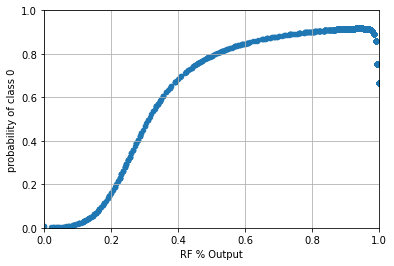

In [86]:
df_test1.plot.scatter(x='pred_0', y='prob_0')
plt.xlabel('RF % Output')
plt.ylabel('probability of class 0')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()


#plt.savefig('../dataset/RF_output.png')
plt.show()

## Confusion matrix for original predictions

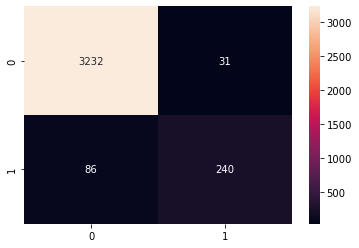

In [28]:
y = df_test1['class'].to_numpy()
y_pred = df_test1.predicted_class.to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Confusion matrix for corrected predictions

In [29]:
y_pred = df_test1['prob_0']

In [30]:
y = df_test1['class'].to_numpy()
y_pred = df_test1['prob_0'].to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [31]:
df_test1.to_csv(DATA/'RF_bayesian_prob_test1_calibration.csv', index=False)

### same for test set 2

In [87]:
df_test2 = pd.read_csv(f'{CHEMBL205}/CHEMBL205_predictions_RF_test2_demonstration.csv')
df_test2.head()

,class,predictions,predicted_class
0,1,[0.405 0.595],1
1,1,[0.075 0.925],1
2,0,[0.945 0.055],0
3,0,[0.975 0.025],0
4,0,[0.95 0.05],0


In [88]:
df_test2['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2.iterrows()] # str to list
df_test2['pred_0'] = [r['preds'][0] for i, r in df_test2.iterrows()]
df_test2.head()

,class,predictions,predicted_class,preds,pred_0
0,1,[0.405 0.595],1,"[0.405, 0.595]",0.405
1,1,[0.075 0.925],1,"[0.075, 0.925]",0.075
2,0,[0.945 0.055],0,"[0.945, 0.055]",0.945
3,0,[0.975 0.025],0,"[0.975, 0.025]",0.975
4,0,[0.95 0.05],0,"[0.95, 0.05]",0.950


In [89]:
df_test2 = df_test2.drop(columns=['predictions', 'preds'])
df_test2.head()

,class,predicted_class,pred_0
0,1,1,0.405
1,1,1,0.075
2,0,0,0.945
3,0,0,0.975
4,0,0,0.950


In [90]:
preds = df_test2.pred_0

In [91]:
arr = df_test2[df_test2['pred_0'] == 0.5]
arr = arr[arr['predicted_class'] == 0]
arr

,class,predicted_class,pred_0
2167,1,0,0.5
2330,1,0,0.5
2430,1,0,0.5
3317,1,0,0.5
3358,1,0,0.5


In [92]:
df_test2 = make_equal_pred_rand(df_test2)

In [93]:
arr = df_test2[df_test2['pred_0'] == 0.5]
arr

,class,predicted_class,pred_0
2167,1,0,0.5
2330,1,1,0.5
2430,1,1,0.5
3317,1,0,0.5
3358,1,0,0.5


In [94]:
probs_0 = get_probs_RF(preds, 0)
probs_0

array([0.69187775, 0.00913665, 0.91693854, ..., 0.89323331, 0.90493876,
       0.86102612])

In [95]:
df_test2['prob_0'] = probs_0
df_test2.head()

,class,predicted_class,pred_0,prob_0
0,1,1,0.405,0.691878
1,1,1,0.075,0.009137
2,0,0,0.945,0.916939
3,0,0,0.975,0.910338
4,0,0,0.950,0.916795


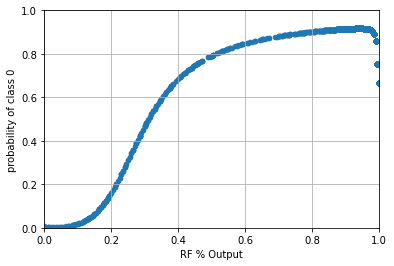

In [100]:
df_test2.plot.scatter(x='pred_0', y='prob_0')
plt.xlabel('RF % Output')
plt.ylabel('probability of class 0')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()


#plt.savefig('../dataset/RF_output.png')
plt.show()

In [96]:
df_test2.to_csv(DATA/'RF_bayesian_prob_test2_demonstration.csv', index=False) # save bayesian probabilites as csv

In [97]:
def choose_class(x, um):
    """
    x = either one number between 0-1, or a (normalized) vector of probabilities
        if it's one number then we are in a binary classification case
        and x is the probability of CLASS 0
    um = utility matrix in the format [[T0,F0],[F1,T1]]
    """
    if type(x) == float or type(x) == np.float64: # x is float and is the probability of class 0
        x = np.array([x])
        x = np.concatenate((x, 1-x)) # transform into prob. vector
    um = np.array(um)
    utilities = np.matmul(um, x)
    cl = np.argmax(utilities)
    return cl

## Test score for regular probability and bayesian probability from utility matrix

In [98]:
df_test2.head() # actual class, prediction from RF, bayesian corrected probability 

,class,predicted_class,pred_0,prob_0
0,1,1,0.405,0.691878
1,1,1,0.075,0.009137
2,0,0,0.945,0.916939
3,0,0,0.975,0.910338
4,0,0,0.950,0.916795


### We need to calculate each class chosen with the same utility matrix and then compare

In [99]:
from IPython.display import IFrame
IFrame(DATA/'comparison_schema.pdf', width=1000, height=600)

In [40]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
um = np.array([[1, -1], [0, 1]])

In [61]:
xs = df_test2['pred_0'].to_numpy()
xs

array([0.975, 0.99 , 0.95 , ..., 0.99 , 0.3  , 0.975])

In [76]:
df_test2['class_pred_0'] = np.array(df_test2['pred_0'] < 0.5, dtype=int)
df_test2.head()

,class,pred_0,prob_0,ut_class_prob_0,class_pred_0
0,0,0.975,0.997848,0,0
1,0,0.990,0.998329,0,0
2,0,0.950,0.995933,0,0
3,0,0.995,0.998112,0,0
4,1,0.105,0.092222,1,1


In [43]:
df_test2['ut_class_prob_0'] = [choose_class(r['prob_0'], um) for i, r  in df_test2.iterrows()]
df_test2.head()

,class,pred_0,prob_0,ut_class_pred_0,ut_class_prob_0
0,0,0.975,0.997848,0,0
1,0,0.990,0.998329,0,0
2,0,0.950,0.995933,0,0
3,0,0.995,0.998112,0,0
4,1,0.105,0.092222,1,1


### Check confusion matrix for the 2 outputs from the utility matrix

In [9]:
def get_total_cost (um, cm):
    if um.max() > 1: # highest number in utility matrix == 1
        um /= np.abs(um).max()
    s = um * cm
    s = s.sum()
    return s

In [100]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
um = np.array([[1, 0], [-1, 1]])

Confusion matrix for RF output:


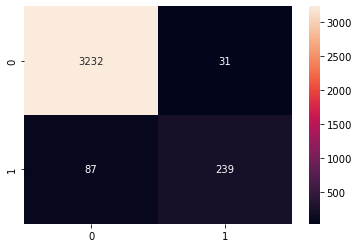

In [107]:
# Confusion matrix for RF output
y = df_test2['class'].to_numpy()
y_pred = df_test2['class_pred_0'].to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
print('Confusion matrix for RF output:')
plt.show()

In [108]:
cost = get_total_cost(um, cm)
print(f'Total gains/loss for confusion matrix above: {cost}')

Total gains/loss for confusion matrix above: 3384


Confusion matrix for bayesian probability output combined with utility matrix:


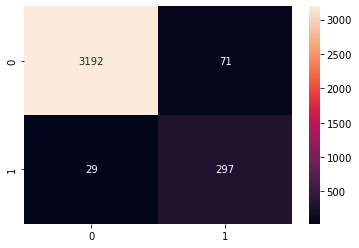

In [109]:
# Confusion matrix for bayesian probability output combined with utility matrix
y = df_test2['class'].to_numpy()
y_pred = df_test2['ut_class_prob_0'].to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
print('Confusion matrix for bayesian probability output combined with utility matrix:')
plt.show()

In [110]:
cost = get_total_cost(um, cm)
print(f'Total gains/loss for confusion matrix above: {cost}')

Total gains/loss for confusion matrix above: 3460


# Decision theory

### Test an example with gains/losses

In [54]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
M = np.array([[15,-80],
              [-1,0]], dtype=float)
#M /= np.abs(M).max()
M = torch.from_numpy(M)
M = M.to(torch.float64)
M

tensor([[ 15., -80.],
        [ -1.,   0.]], dtype=torch.float64)

In [55]:
test1 = np.array([[0.18, 0.02], [0.32, 0.48]], dtype=np.float64)
test2 = np.array([[0.16, 0.04], [0.08, 0.72]], dtype=np.float64)

In [56]:
res1 = M * test1
res2 = M * test2

In [57]:
sum1, sum2 = res1.sum(), res2.sum()
print('Gains from algorithms:')
print(f'#1 {sum1:.2f}, #2 {sum2:.2f}')

Gains from algorithms:
#1 0.78, #2 -0.88


### Create a function for a utility matrix with cost for each case (TN, FP, FN, TP)

In [73]:
def get_expected_cost (um, m):
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [122]:
cm = confusion_matrix(y, y_pred)
cm

array([[3231,   31],
       [  87,  239]])

In [146]:
cost = get_cost(utility, cm[1])
cost

326.0

In [141]:
c = get_expected_cost(utility, cm)
c

[3231.0, 239.0]

In [163]:
df_all['probs'] = [[r['probs_class_0'], r['probs_class_1']] for i, r in df_all.iterrows()]
df_all.head()

,class,preds,probs_class_0,probs_class_1,prediction,probs
0,0,0.975,0.997848,0.002152,0,"[0.9978484371013459, 0.002151562898654075]"
1,0,0.990,0.998329,0.001671,0,"[0.998328584124416, 0.0016714158755837688]"
2,0,0.950,0.995933,0.004067,0,"[0.9959327602479192, 0.004067239752081032]"
3,0,0.995,0.998112,0.001888,0,"[0.9981116284172469, 0.0018883715827530312]"
4,1,0.105,0.092222,0.907778,1,"[0.09222187670619506, 0.9077781232938047]"


In [10]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, -1], 
                    [-1, 1]], dtype=np.float64)

In [11]:
def get_expected_utility (um, m):
    '''
    um = utility matrix in format     [[TN, FN], [FP, TP]]
    m = prediction or probability of class [0, 1]
    returns expected utility for each class
    '''
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [171]:
df_all['expected_utility'] = [get_expected_utility(utility, r['probs']) for i, r in df_all.iterrows()]
df_all['best_utility_class'] = torch.tensor(df_all['expected_utility']).argmax(axis=1)
df_utility = df_all.drop(columns= ['prediction', 'preds'])
df_utility.head()

,class,probs_class_0,probs_class_1,probs,expected_utility,best_utility_class
0,0,0.997848,0.002152,"[0.9978484371013459, 0.002151562898654075]","[0.9956968742026918, -0.9956968742026918]",0
1,0,0.998329,0.001671,"[0.998328584124416, 0.0016714158755837688]","[0.9966571682488323, -0.9966571682488323]",0
2,0,0.995933,0.004067,"[0.9959327602479192, 0.004067239752081032]","[0.9918655204958382, -0.9918655204958382]",0
3,0,0.998112,0.001888,"[0.9981116284172469, 0.0018883715827530312]","[0.9962232568344939, -0.9962232568344939]",0
4,1,0.092222,0.907778,"[0.09222187670619506, 0.9077781232938047]","[-0.8155562465876096, 0.8155562465876096]",1


In [ ]:
df_utility.to_csv(DATA/'RF_prob_utility_test2.csv', index=False)

# Generate correct probabilities for CNN model for test1 and test2

In [7]:
df_CNN = pd.read_csv(DATA/'_CNN_transducer_parameters.csv')
df_CNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       262144 non-null  float64
 1   p       262144 non-null  float64
 2   mu0     262144 non-null  float64
 3   sigma0  262144 non-null  float64
 4   mu1     262144 non-null  float64
 5   sigma1  262144 non-null  float64
dtypes: float64(6)
memory usage: 12.0 MB


In [8]:
df_CNN.head()

,w,p,mu0,sigma0,mu1,sigma1
0,1.112537e-308,0.145600,4.631813,0.553028,-3.420113,1.102329
1,1.112537e-308,0.822009,2.747586,0.668505,-3.778652,0.188885
2,1.002707e-305,0.528113,2.208753,0.380289,-5.060915,5.128923
3,6.536115e-292,0.863495,0.841832,4.170368,-4.375486,0.591010
4,1.716880e-283,0.649723,2.634691,0.139720,-4.135932,1.172759


In [9]:
#function for making a list of strings in df to list of floats
def get_substring_list(split):
    if len(split) <= 1:
        print('nooo')
    i = 0
    while len(split[i]) <= 1:
        i += 1
    s1 = split[i]
    i += 1
    while len(split[i]) <= 1:
        i += 1
    s2 = split[i]
    if s1[0] == '[':
        s1 = s1[1:]
    if s2[-1] == ']':
        s2 = s2[0:-1]
    s1 = np.float64(s1)
    s2 = np.float64(s2)
    return [s1, s2]

### Test1

In [10]:
df_test1 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test1_calibration.csv')
df_test1['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test1.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test1.head()

,class,predictions,predicted_class,preds
0,0,[ 0.8859392 -3.1229172],0,"[0.8859392, -3.1229172]"
1,0,[ 3.2430787 -5.6636806],0,"[3.2430787, -5.6636806]"
2,0,[ 3.8554306 -5.8214846],0,"[3.8554306, -5.8214846]"
3,0,[ 3.3478065 -5.4837394],0,"[3.3478065, -5.4837394]"
4,1,[-3.788875 0.15739654],1,"[-3.788875, 0.15739654]"


In [13]:
def calculate_probs_CNN(df, df_preds):
    '''
    function for getting bayesian corrected probabilites for CNN
    df = DataFrame for CNN parameters for the probability function
    df_preds = DataFrame for the predictions
    '''
    
    preds = df_preds['preds']
    all_probs_0 = np.array([])
    if 'mu0' and 'mu1' in df.columns:
        m0 = df.mu0.to_numpy()
        s0 = df.sigma0.to_numpy()
        m1 = df.mu1.to_numpy()
        s1 = df.sigma1.to_numpy()
        p = df.p.to_numpy()
        w = df.w.to_numpy()
        for pred in preds:
            prob = CNN_direct_prob(pred, 0, w, p, m0, s0, m1, s1)
            all_probs_0 = np.append(all_probs_0, prob)
    else:
        m = df.mu.to_numpy()
        s = df.sigma.to_numpy()
        p = df.p.to_numpy()
        w = df.w.to_numpy()
        for pred in preds:
            prob = CNN_direct_prob2(pred, 0, w, p, m, s)
            all_probs_0 = np.append(all_probs_0, prob)
    return all_probs_0

In [14]:
arr = calculate_probs_CNN(df_CNN, df_test1)
arr

array([0.95907946, 0.99773092, 0.99729075, ..., 0.99840165, 0.66175722,
       0.99137177])

In [15]:
len(arr)

3589

In [16]:
df_test1['predictions'] = df_test1['preds']
df_test1['prob_0'] = arr
df_test1 = df_test1.drop(columns=['preds', 'predicted_class'])

In [17]:
df_test1.head()

,class,predictions,prob_0
0,0,"[0.8859392, -3.1229172]",0.959079
1,0,"[3.2430787, -5.6636806]",0.997731
2,0,"[3.8554306, -5.8214846]",0.997291
3,0,"[3.3478065, -5.4837394]",0.997800
4,1,"[-3.788875, 0.15739654]",0.204960


In [18]:
np.max(df_test1['prob_0']), np.min(df_test1['prob_0'])

(0.9984189823751263, 0.09819495244874327)

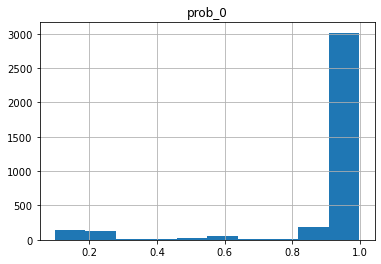

In [19]:
df_test1.hist(column='prob_0')
plt.show()

In [20]:
df_test1.to_csv(DATA/'CNN_bayesian_prob_test1.csv', index=False)

### Do the same for test set 2

In [21]:
df_test2 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test2_demonstration.csv')
df_test2['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test2.head()

,class,predictions,predicted_class,preds
0,1,[-6.1531496 3.5288205],1,"[-6.1531496, 3.5288205]"
1,1,[-5.2736645 2.0863538],1,"[-5.2736645, 2.0863538]"
2,0,[ 2.3478374 -4.10595 ],0,"[2.3478374, -4.10595]"
3,0,[ 1.1088221 -3.4260807],0,"[1.1088221, -3.4260807]"
4,0,[ 1.0482897 -3.2705696],0,"[1.0482897, -3.2705696]"


In [22]:
probs = calculate_probs_CNN(df_CNN, df_test2)

In [23]:
df_test2['predictions'] = df_test2['preds']
df_test2['prob_0'] = probs
df_test2 = df_test2.drop(columns=['preds', 'predicted_class'])

In [24]:
df_test2.head()

,class,predictions,prob_0
0,1,"[-6.1531496, 3.5288205]",0.098276
1,1,"[-5.2736645, 2.0863538]",0.098389
2,0,"[2.3478374, -4.10595]",0.997626
3,0,"[1.1088221, -3.4260807]",0.971378
4,0,"[1.0482897, -3.2705696]",0.964264


In [25]:
df_test2['pred_0'] = [r['predictions'][0] for i, r in df_test2.iterrows()]
df_test2['pred_1'] = [r['predictions'][1] for i, r in df_test2.iterrows()]
df_test2 = df_test2.drop(columns=['predictions'])

In [26]:
df_test2.head()

,class,prob_0,pred_0,pred_1
0,1,0.098276,-6.153150,3.528821
1,1,0.098389,-5.273664,2.086354
2,0,0.997626,2.347837,-4.105950
3,0,0.971378,1.108822,-3.426081
4,0,0.964264,1.048290,-3.270570


In [27]:
df_test2 = df_test2[['class', 'pred_0', 'pred_1', 'prob_0']]
df_test2.head()

,class,pred_0,pred_1,prob_0
0,1,-6.153150,3.528821,0.098276
1,1,-5.273664,2.086354,0.098389
2,0,2.347837,-4.105950,0.997626
3,0,1.108822,-3.426081,0.971378
4,0,1.048290,-3.270570,0.964264


In [28]:
df_test2.to_csv(DATA/'CNN_bayesian_prob_test2_demonstration.csv', index=False)

# Test with CS Loss model

In [113]:
df_test2_cs = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_CS_loss_test2.csv')
df_test2_cs['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2_cs.iterrows()]

In [114]:
df_test2_cs.head()

,class,predictions,predicted_class,preds
0,0,[ 1.9198327 -1.2823217],1.919833,"[1.9198327, -1.2823217]"
1,0,[ 3.725137 -2.178217],3.725137,"[3.725137, -2.178217]"
2,0,[ 7.8391333 -6.633624 ],7.839133,"[7.8391333, -6.633624]"
3,0,[ 7.369962 -6.2871866],7.369962,"[7.369962, -6.2871866]"
4,1,[-1.3934275 2.0953865],2.095387,"[-1.3934275, 2.0953865]"


In [115]:
#probs = calculate_probs_CNN(df_CNN, df_test2_cs)

In [116]:
df_test2_cs['predictions'] = df_test2_cs['preds']
#df_test2_cs['prob_0'] = probs
df_test2_cs = df_test2_cs.drop(columns=['preds', 'predicted_class'])

In [117]:
df_test2_cs['pred_0'] = [r['predictions'][0] for i, r in df_test2_cs.iterrows()]
df_test2_cs['pred_1'] = [r['predictions'][1] for i, r in df_test2_cs.iterrows()]
df_test2_cs = df_test2_cs.drop(columns=['predictions'])

In [118]:
df_test2_cs.head()

,class,pred_0,pred_1
0,0,1.919833,-1.282322
1,0,3.725137,-2.178217
2,0,7.839133,-6.633624
3,0,7.369962,-6.287187
4,1,-1.393428,2.095387


In [119]:
df_test2_cs.to_csv(DATA/'CNN_prob_CS_loss_test2_demonstration.csv', index=False)

## Test for utility matrix

In [136]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, 0], 
                    [0, 1]], dtype=np.float64)

In [138]:
df = df_preds
df['expected_utility'] = [get_expected_utility(utility, [r['direct_prob_0'], 1 - r['direct_prob_0']]) 
                          for i, r in df.iterrows()]
df['best_utility_class'] = torch.tensor(df['expected_utility']).argmax(axis=1)

In [139]:
df.head()

,class,predictions,predicted_class,direct_prob_0,expected_utility,best_utility_class
0,0,"[1.0686345, 0.15982893]",0,0.812227,"[0.8122267607382875, 0.18777323926171252]",0
1,0,"[3.294972, -3.2591784]",0,0.997830,"[0.997829581810393, 0.0021704181896069485]",0
2,0,"[3.8328488, -3.5713756]",0,0.995896,"[0.9958956353188672, 0.004104364681132844]",0
3,0,"[3.1314778, -3.682592]",0,0.997027,"[0.9970271557275053, 0.002972844272494668]",0
4,1,"[-0.789468, 1.3680037]",1,0.230961,"[0.2309608425386519, 0.7690391574613481]",1


,class,direct_prob_0,prediction_0
0,0,0.812227,1.068634
1,0,0.997830,3.294972
2,0,0.995896,3.832849
3,0,0.997027,3.131478
4,1,0.230961,-0.789468


In [189]:
df_save = df_preds
df_save.to_csv(DATA/'CNN_direct_prob.csv', index=False)

# Create and compare different utility matrix for test set 2 in CNN and RF models

In [29]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
ums = {
    'um1' : [[1, 0], [0, 1]], # accuracy
    'um2' : [[1, -10], [0, 10]],
    'um3' : [[1, -100], [0, 100]],
    'um4' : [[10, 0], [-10, 1]],
    'um5' : [[100, 0], [-100, 10]]
    
}

## Test for random forest model

In [30]:
def choose_class(x, um=None):
    """
    x = either one number between 0-1, or a (normalized) vector of probabilities
        if it's one number then we are in a binary classification case
        and x is the probability of CLASS 0
    um = utility matrix in the format [[T0,F0],[F1,T1]] if None: Choose class based on x
    """
    if type(x) == float or type(x) == np.float64: # x is float and is the probability of class 0
        x = np.array([x])
        x = np.concatenate((x, 1-x)) # transform into prob. vector       
    else:
        x = torch.sigmoid(torch.tensor(x))
        x = np.array(x)
    if um != None:
        um = np.array(um)
        x = np.matmul(um, x)
    if x[0] == x[1]:
        cl = random.randint(0,1)
    else:
        cl = np.argmax(x)
    return cl

In [31]:
def get_total_cost (um, cm):
    um = np.array([np.array(x) for x in um])
    um = np.array([[um[0][0], um[1][0]], [um[0][1], um[1][1]]]) # switch the ordering of                             
    um = um - um.min()                                          #t he cm to match [[TN, FP], [FN, TP]]
    um = um / um.max() # Matrix to have max = 1 and min = 0
    s = um * cm
    s = s.sum()
    s = s / cm.sum()
    return s

In [32]:
df_test2_RF = pd.read_csv(DATA/'RF_bayesian_prob_test2_demonstration.csv')
df_test2_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            3588 non-null   int64  
 1   predicted_class  3588 non-null   int64  
 2   pred_0           3588 non-null   float64
 3   prob_0           3588 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 112.2 KB


In [33]:
df_test2_RF.head()

,class,predicted_class,pred_0,prob_0
0,1,1,0.405,0.691878
1,1,1,0.075,0.009137
2,0,0,0.945,0.916939
3,0,0,0.975,0.910338
4,0,0,0.950,0.916795


In [34]:
#df_test2_RF['predictions'] = [np.array([r['pred_0'], 1. - r['pred_0']]) for i, r in df_test2_RF.iterrows()]
#df_test2_RF['probabilities'] = [np.array([r['prob_0'], 1 - r['prob_0']]) for i, r in df_test2_RF.iterrows()]
df_test2_RF.head()

,class,predicted_class,pred_0,prob_0
0,1,1,0.405,0.691878
1,1,1,0.075,0.009137
2,0,0,0.945,0.916939
3,0,0,0.975,0.910338
4,0,0,0.950,0.916795


In [35]:
df_scores = pd.DataFrame()
df_scores['ums'] = list(ums.values())

In [36]:
df_scores

,ums
0,"[[1, 0], [0, 1]]"
1,"[[1, -10], [0, 10]]"
2,"[[1, -100], [0, 100]]"
3,"[[10, 0], [-10, 1]]"
4,"[[100, 0], [-100, 10]]"


In [53]:
def get_utility_scores(df, um, verbose=True):
    '''
    Method for calculating the total gains from utility matrix for regular predictions 
    and bayesian corrected predictions
    df = DataFrame for predictions and bayesian probabilites of class 0
    um = utility matrix in the format [[T0,F0],[F1,T1]]
    verbose = if True: Outputs confusion matrix and text
    '''
    c1, c2, c3 = 0, 0, 0
    # Calculations for standard output
    y = df['class'].to_numpy()
    if 'pred_1' in df.columns:
        y_pred = [choose_class([r['pred_0'], r['pred_1']]) for i, r in df.iterrows()]
    else:
        y_pred = [choose_class(r['pred_0']) for i, r in df.iterrows()]
    cm1 = confusion_matrix(y, y_pred)
    c1 = get_total_cost(um, cm1)
    if verbose: 
        f = sns.heatmap(cm1, annot=True, fmt='d')
        print('**Output for the standard predictions from algorithm**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c1}')
        print('Confusion matrix:')
        plt.show()
    # Calculations for standard output with expected utility class choice
    if 'pred_1' in df.columns:
        y_pred = [choose_class([r['pred_0'], r['pred_1']], um) for i, r in df.iterrows()]
    else:
        y_pred = [choose_class(r['pred_0'], um) for i, r in df.iterrows()]
    cm2 = confusion_matrix(y, y_pred)
    c2 = get_total_cost(um, cm2)
    if verbose: 
        f = sns.heatmap(cm2, annot=True, fmt='d')
        print('**Output for the standard predictions mixed expected utility**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c2}')
        print('Confusion matrix:')
        plt.show()
    if 'prob_0' in df.columns: 
        # Calculations for bayesian probability and expected utility class choice
        y_pred = [choose_class(r['prob_0'], um) for i, r in df.iterrows()]
        cm3 = confusion_matrix(y, y_pred)
        c3 = get_total_cost(um, cm3)
        if verbose: 
            f = sns.heatmap(cm3, annot=True, fmt='d')
            print('**Output for the transducer**')
            print(f'Utility Matrix: {um}')
            print(f'Total gains: {c3}')
            print('Confusion matrix:')
            plt.show()
    return c1, c2, c3

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains for the Utility Matrix: 0.5739269788182831
Confusion matrix:


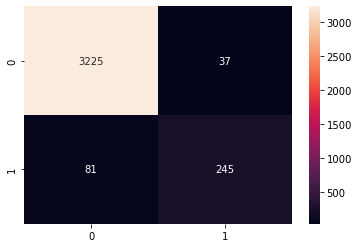

**Output for the standard predictions mixed expected utility**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains for the Utility Matrix: 0.5736622073578596
Confusion matrix:


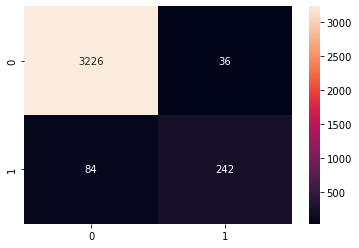

**Output for the transducer**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains: 0.5643952062430324
Confusion matrix:


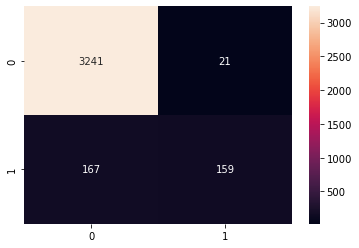

In [56]:
c1, c2, c3 = get_utility_scores(df_test2_RF, [[1, 0], [-10, 10]])

In [98]:
df_scores.iloc[0].to_numpy()

array([list([[1, 0], [0, 1]])], dtype=object)

In [99]:
um = np.array([[1, 0], [0, 1]])

In [100]:
um = um - um.min()
um = um / um.max()
um

array([[1., 0.],
       [0., 1.]])

In [101]:
um[1][1]

1.0

# Get the scores for all the different utility matrixes

In [49]:
df_scores = pd.DataFrame()
df_scores['ums'] = list(ums.values())

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, 0], [0, 1]]
Total gains for the Utility Matrix: 0.967670011148272
Confusion matrix:


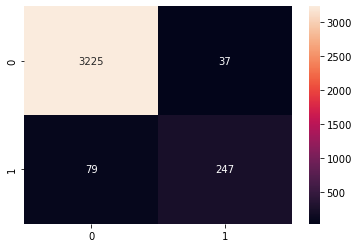

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, 0], [0, 1]]
Total gains for the Utility Matrix: 0.967391304347826
Confusion matrix:


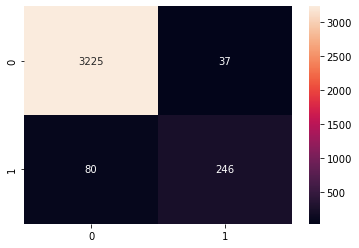

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, 0], [0, 1]]
Total gains: 0.9501114827201784
Confusion matrix:


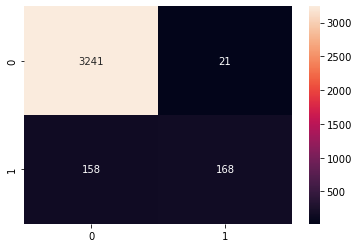

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, -10], [0, 10]]
Total gains for the Utility Matrix: 0.5680741360089187
Confusion matrix:


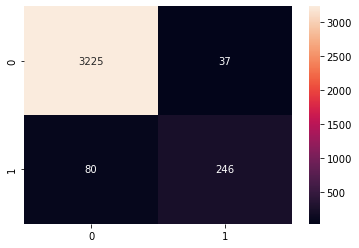

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, -10], [0, 10]]
Total gains for the Utility Matrix: 0.5777313266443701
Confusion matrix:


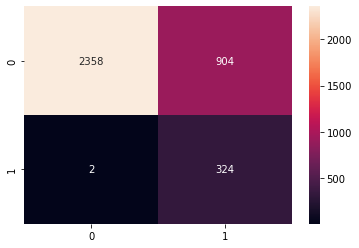

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, -10], [0, 10]]
Total gains: 0.5454292084726867
Confusion matrix:


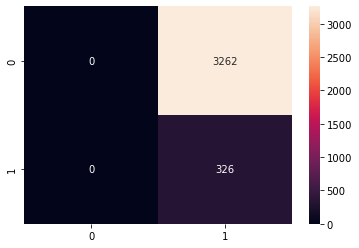

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, -100], [0, 100]]
Total gains for the Utility Matrix: 0.5276268115942029
Confusion matrix:


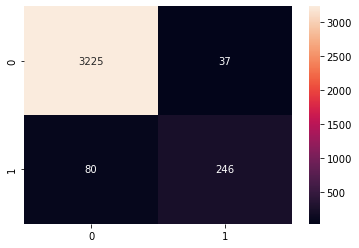

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, -100], [0, 100]]
Total gains for the Utility Matrix: 0.5456605351170568
Confusion matrix:


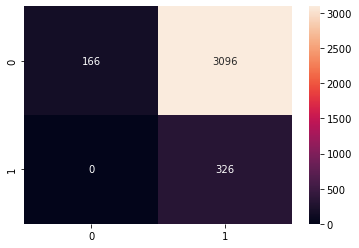

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, -100], [0, 100]]
Total gains: 0.5454292084726867
Confusion matrix:


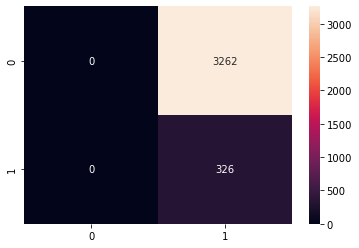

**Output for the standard predictions from algorithm**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains for the Utility Matrix: 0.9477006688963211
Confusion matrix:


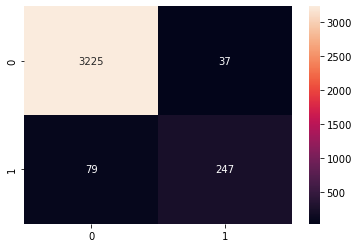

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains for the Utility Matrix: 0.9541666666666667
Confusion matrix:


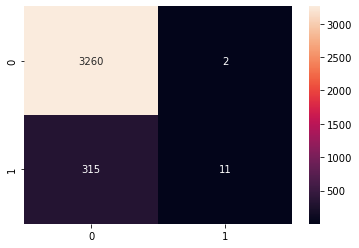

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains: 0.9534698996655518
Confusion matrix:


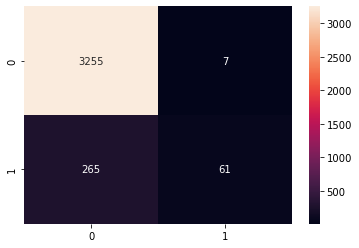

**Output for the standard predictions from algorithm**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains for the Utility Matrix: 0.9476727982162765
Confusion matrix:


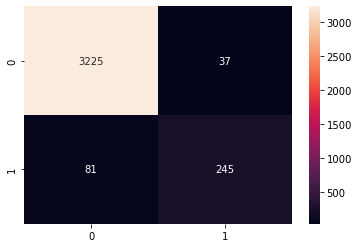

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains for the Utility Matrix: 0.9541666666666667
Confusion matrix:


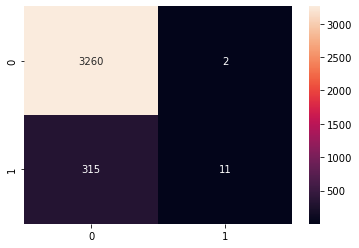

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains: 0.9534698996655518
Confusion matrix:


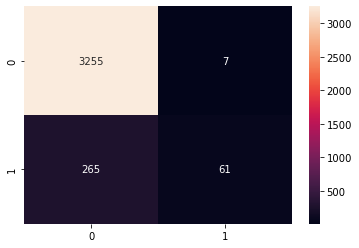

[0.9501114827201784,
 0.5454292084726867,
 0.5454292084726867,
 0.9534698996655518,
 0.9534698996655518]

In [40]:
scores1 = []
scores2 = []
scores3 = []
for i, r in df_scores.iterrows():
    s1, s2, s3 = get_utility_scores(df_test2_RF, r['ums'], verbose=True)
    scores1.append(s1)
    scores2.append(s2)
    scores3.append(s3)
scores3

In [50]:
df_scores['RF_standard'] = scores1
df_scores['RF_mixed'] = scores2
df_scores['RF_transducer'] = scores3
df_scores

,ums,RF_standard,RF_mixed,RF_transducer
0,"[[1, 0], [0, 1]]",0.959309,0.959309,0.960981
1,"[[1, -10], [0, 10]]",0.575878,0.581090,0.582302
2,"[[1, -100], [0, 100]]",0.536183,0.546435,0.547860
3,"[[10, 0], [-10, 1]]",0.931396,0.949275,0.954571
4,"[[100, 0], [-100, 10]]",0.931396,0.949275,0.954571


In [42]:
df_test2_CNN = pd.read_csv(DATA/'CNN_bayesian_prob_test2_demonstration.csv')
df_test2_CNN.head()

,class,pred_0,pred_1,prob_0
0,1,-6.153150,3.528821,0.098276
1,1,-5.273664,2.086354,0.098389
2,0,2.347837,-4.105950,0.997626
3,0,1.108822,-3.426081,0.971378
4,0,1.048290,-3.270570,0.964264


In [43]:
df_test2_CNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   3588 non-null   int64  
 1   pred_0  3588 non-null   float64
 2   pred_1  3588 non-null   float64
 3   prob_0  3588 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 112.2 KB


**Output for the standard predictions from algorithm**
Utility Matrix: [[1, 0], [0, 1]]
Total gains for the Utility Matrix: 0.9593088071348941
Confusion matrix:


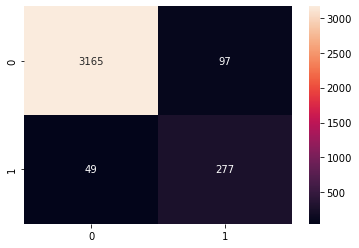

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, 0], [0, 1]]
Total gains for the Utility Matrix: 0.9593088071348941
Confusion matrix:


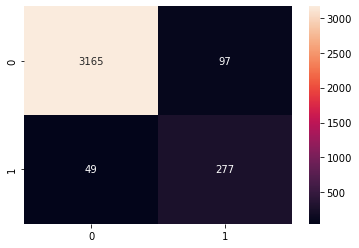

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, 0], [0, 1]]
Total gains: 0.9609810479375697
Confusion matrix:


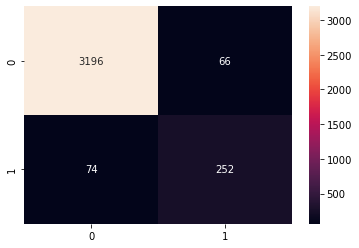

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, -10], [0, 10]]
Total gains for the Utility Matrix: 0.5758779264214047
Confusion matrix:


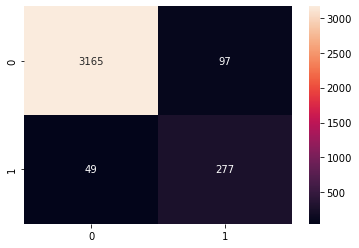

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, -10], [0, 10]]
Total gains for the Utility Matrix: 0.5810897435897435
Confusion matrix:


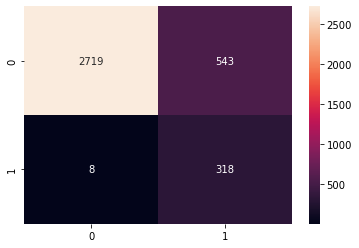

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, -10], [0, 10]]
Total gains: 0.5823021181716834
Confusion matrix:


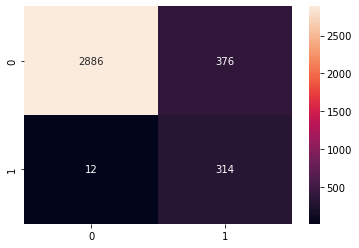

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, -100], [0, 100]]
Total gains for the Utility Matrix: 0.536183110367893
Confusion matrix:


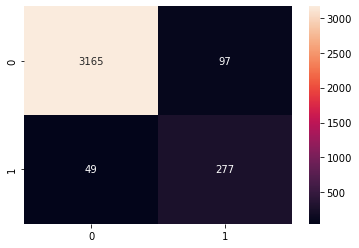

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, -100], [0, 100]]
Total gains for the Utility Matrix: 0.5464353400222965
Confusion matrix:


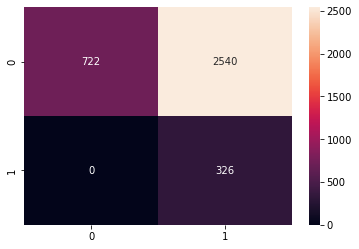

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, -100], [0, 100]]
Total gains: 0.5478595317725753
Confusion matrix:


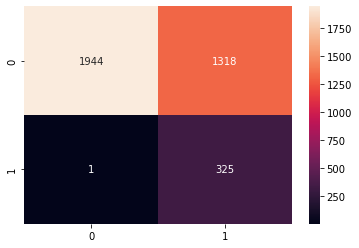

**Output for the standard predictions from algorithm**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains for the Utility Matrix: 0.9313963210702341
Confusion matrix:


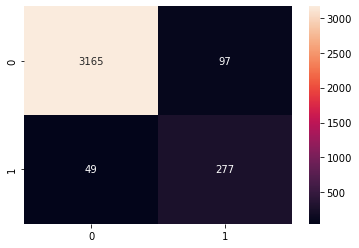

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains for the Utility Matrix: 0.9492753623188406
Confusion matrix:


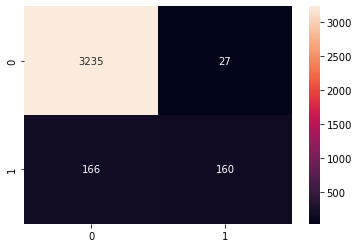

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[10, 0], [-10, 1]]
Total gains: 0.9545707915273133
Confusion matrix:


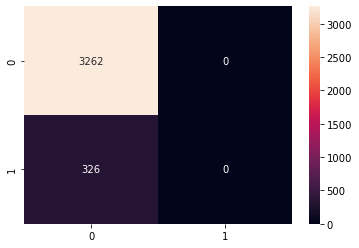

**Output for the standard predictions from algorithm**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains for the Utility Matrix: 0.9313963210702341
Confusion matrix:


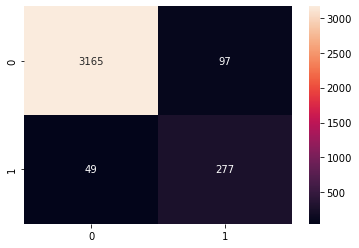

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains for the Utility Matrix: 0.9492753623188406
Confusion matrix:


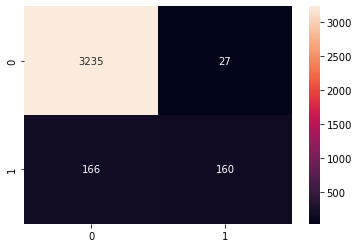

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[100, 0], [-100, 10]]
Total gains: 0.9545707915273133
Confusion matrix:


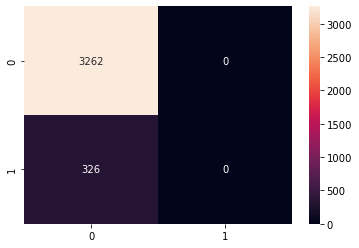

[0.9609810479375697,
 0.5823021181716834,
 0.5478595317725753,
 0.9545707915273133,
 0.9545707915273133]

In [45]:
scores1 = []
scores2 = []
scores3 = []
for i, r in df_scores.iterrows():
    s1, s2, s3 = get_utility_scores(df_test2_CNN, r['ums'], verbose=True)
    scores1.append(s1)
    scores2.append(s2)
    scores3.append(s3)
scores3

In [51]:
df_scores['CNN_standard'] = scores1
df_scores['CNN_mixed'] = scores2
df_scores['CNN_transducer'] = scores3
df_scores

,ums,RF_standard,RF_mixed,RF_transducer,CNN_standard,CNN_mixed,CNN_transducer
0,"[[1, 0], [0, 1]]",0.959309,0.959309,0.960981,0.959309,0.959309,0.960981
1,"[[1, -10], [0, 10]]",0.575878,0.581090,0.582302,0.575878,0.581090,0.582302
2,"[[1, -100], [0, 100]]",0.536183,0.546435,0.547860,0.536183,0.546435,0.547860
3,"[[10, 0], [-10, 1]]",0.931396,0.949275,0.954571,0.931396,0.949275,0.954571
4,"[[100, 0], [-100, 10]]",0.931396,0.949275,0.954571,0.931396,0.949275,0.954571


### Add Cost-sensitive model

In [28]:
df_test2_CS = pd.read_csv(DATA/'CNN_CS_loss_test2.csv')

In [29]:
df_test2_CS.head()

,class,pred_um1,pred_um2,pred_um3,pred_um4,pred_um5,pred_um6,pred_um7,pred_um8,pred_um9,pred_um10,pred_um11,pred_um12,pred_um13,pred_um14,pred_um15
0,0,[0.97661906 0.0111127 ],[0.94917387 0.04463243],[0.7171942 0.31330645],[0.9843002 0.00847411],[0.9145431 0.0901518],[0.78320813 0.17060214],[0.98369575 0.0468426 ],[0.99487054 0.02101552],[0.9941069 0.01856612],[0.9444596 0.0648237],[0.95143163 0.02702073],[0.94760525 0.1339803 ],[0.92992324 0.1718466 ],[0.9855479 0.01165897],[0.7466417 0.15343355]
1,0,[0.9981341 0.00117332],[0.9861733 0.01402404],[0.9928934 0.00393965],[0.9776924 0.01049647],[0.9865953 0.01231423],[0.9930335 0.01160094],[0.9935597 0.00672642],[0.9973001 0.01140507],[0.997145 0.00653503],[0.99035794 0.01116317],[0.99027514 0.0078122 ],[0.97382396 0.04402433],[0.9929431 0.02474658],[9.990683e-01 9.792164e-04],[0.98346 0.01062883]
2,0,[9.9975938e-01 1.7769024e-04],[0.998412 0.00116792],[9.9967206e-01 4.5852657e-04],[9.994134e-01 7.175277e-04],[0.99469155 0.00347157],[0.99133015 0.00953034],[9.9978060e-01 1.5728366e-04],[0.99856263 0.00687149],[0.9998858 0.00142944],[0.99764377 0.0043822 ],[0.9969919 0.00161885],[0.99432725 0.00804781],[0.9976272 0.00381821],[9.9969804e-01 1.4555233e-04],[0.9938937 0.00428178]
3,0,[9.990115e-01 7.346845e-04],[9.993293e-01 7.536346e-04],[0.9968088 0.00255448],[0.9846784 0.00673459],[0.99429 0.00582641],[0.9956031 0.00629928],[0.99919957 0.00122478],[0.9973502 0.00827719],[0.99935836 0.00247604],[0.9933488 0.01155344],[0.9916889 0.01182056],[0.99294853 0.02502685],[0.995565 0.00845183],[0.99611914 0.00363934],[0.99563736 0.00285478]
4,1,[0.02032536 0.9665286 ],[0.03184715 0.95556325],[0.00420866 0.9967181 ],[0.04752765 0.9571476 ],[0.07324732 0.8965421 ],[0.03229338 0.9715555 ],[0.0527445 0.94935584],[0.08429085 0.97633684],[0.07859739 0.9544279 ],[0.01222073 0.98635966],[0.03319311 0.90294194],[0.15405147 0.90844566],[0.01711109 0.988811 ],[0.11780601 0.88821244],[0.03007631 0.90666366]


In [30]:
for col in df_test2_CS.columns[1:]:
    df_test2_CS[col] = [get_substring_list(r[col].split(' '))  for i, r in df_test2_CS.iterrows()]

In [31]:
df_test2_CS.head()

,class,pred_um1,pred_um2,pred_um3,pred_um4,pred_um5,pred_um6,pred_um7,pred_um8,pred_um9,pred_um10,pred_um11,pred_um12,pred_um13,pred_um14,pred_um15
0,0,"[0.97661906, 0.0111127]","[0.94917387, 0.04463243]","[0.7171942, 0.31330645]","[0.9843002, 0.00847411]","[0.9145431, 0.0901518]","[0.78320813, 0.17060214]","[0.98369575, 0.0468426]","[0.99487054, 0.02101552]","[0.9941069, 0.01856612]","[0.9444596, 0.0648237]","[0.95143163, 0.02702073]","[0.94760525, 0.1339803]","[0.92992324, 0.1718466]","[0.9855479, 0.01165897]","[0.7466417, 0.15343355]"
1,0,"[0.9981341, 0.00117332]","[0.9861733, 0.01402404]","[0.9928934, 0.00393965]","[0.9776924, 0.01049647]","[0.9865953, 0.01231423]","[0.9930335, 0.01160094]","[0.9935597, 0.00672642]","[0.9973001, 0.01140507]","[0.997145, 0.00653503]","[0.99035794, 0.01116317]","[0.99027514, 0.0078122]","[0.97382396, 0.04402433]","[0.9929431, 0.02474658]","[0.9990683, 0.0009792164]","[0.98346, 0.01062883]"
2,0,"[0.99975938, 0.00017769024]","[0.998412, 0.00116792]","[0.99967206, 0.00045852657]","[0.9994134, 0.0007175277]","[0.99469155, 0.00347157]","[0.99133015, 0.00953034]","[0.9997806, 0.00015728366]","[0.99856263, 0.00687149]","[0.9998858, 0.00142944]","[0.99764377, 0.0043822]","[0.9969919, 0.00161885]","[0.99432725, 0.00804781]","[0.9976272, 0.00381821]","[0.99969804, 0.00014555233]","[0.9938937, 0.00428178]"
3,0,"[0.9990115, 0.0007346845]","[0.9993293, 0.0007536346]","[0.9968088, 0.00255448]","[0.9846784, 0.00673459]","[0.99429, 0.00582641]","[0.9956031, 0.00629928]","[0.99919957, 0.00122478]","[0.9973502, 0.00827719]","[0.99935836, 0.00247604]","[0.9933488, 0.01155344]","[0.9916889, 0.01182056]","[0.99294853, 0.02502685]","[0.995565, 0.00845183]","[0.99611914, 0.00363934]","[0.99563736, 0.00285478]"
4,1,"[0.02032536, 0.9665286]","[0.03184715, 0.95556325]","[0.00420866, 0.9967181]","[0.04752765, 0.9571476]","[0.07324732, 0.8965421]","[0.03229338, 0.9715555]","[0.0527445, 0.94935584]","[0.08429085, 0.97633684]","[0.07859739, 0.9544279]","[0.01222073, 0.98635966]","[0.03319311, 0.90294194]","[0.15405147, 0.90844566]","[0.01711109, 0.988811]","[0.11780601, 0.88821244]","[0.03007631, 0.90666366]"


In [32]:
for col in df_test2_CS.columns[1:]:
    df_test2_CS[f'{col}_0'] = [r[col][0] for i, r in df_test2_CS.iterrows()]
    df_test2_CS[f'{col}_1'] = [r[col][1] for i, r in df_test2_CS.iterrows()]

In [33]:
df_test2_CS.head()

,class,pred_um1,pred_um2,pred_um3,pred_um4,pred_um5,pred_um6,pred_um7,pred_um8,pred_um9,...,pred_um11_0,pred_um11_1,pred_um12_0,pred_um12_1,pred_um13_0,pred_um13_1,pred_um14_0,pred_um14_1,pred_um15_0,pred_um15_1
0,0,"[0.97661906, 0.0111127]","[0.94917387, 0.04463243]","[0.7171942, 0.31330645]","[0.9843002, 0.00847411]","[0.9145431, 0.0901518]","[0.78320813, 0.17060214]","[0.98369575, 0.0468426]","[0.99487054, 0.02101552]","[0.9941069, 0.01856612]",...,0.951432,0.027021,0.947605,0.133980,0.929923,0.171847,0.985548,0.011659,0.746642,0.153434
1,0,"[0.9981341, 0.00117332]","[0.9861733, 0.01402404]","[0.9928934, 0.00393965]","[0.9776924, 0.01049647]","[0.9865953, 0.01231423]","[0.9930335, 0.01160094]","[0.9935597, 0.00672642]","[0.9973001, 0.01140507]","[0.997145, 0.00653503]",...,0.990275,0.007812,0.973824,0.044024,0.992943,0.024747,0.999068,0.000979,0.983460,0.010629
2,0,"[0.99975938, 0.00017769024]","[0.998412, 0.00116792]","[0.99967206, 0.00045852657]","[0.9994134, 0.0007175277]","[0.99469155, 0.00347157]","[0.99133015, 0.00953034]","[0.9997806, 0.00015728366]","[0.99856263, 0.00687149]","[0.9998858, 0.00142944]",...,0.996992,0.001619,0.994327,0.008048,0.997627,0.003818,0.999698,0.000146,0.993894,0.004282
3,0,"[0.9990115, 0.0007346845]","[0.9993293, 0.0007536346]","[0.9968088, 0.00255448]","[0.9846784, 0.00673459]","[0.99429, 0.00582641]","[0.9956031, 0.00629928]","[0.99919957, 0.00122478]","[0.9973502, 0.00827719]","[0.99935836, 0.00247604]",...,0.991689,0.011821,0.992949,0.025027,0.995565,0.008452,0.996119,0.003639,0.995637,0.002855
4,1,"[0.02032536, 0.9665286]","[0.03184715, 0.95556325]","[0.00420866, 0.9967181]","[0.04752765, 0.9571476]","[0.07324732, 0.8965421]","[0.03229338, 0.9715555]","[0.0527445, 0.94935584]","[0.08429085, 0.97633684]","[0.07859739, 0.9544279]",...,0.033193,0.902942,0.154051,0.908446,0.017111,0.988811,0.117806,0.888212,0.030076,0.906664


In [34]:
list(df_test2_CS.columns[16:])

['pred_um1_0',
 'pred_um1_1',
 'pred_um2_0',
 'pred_um2_1',
 'pred_um3_0',
 'pred_um3_1',
 'pred_um4_0',
 'pred_um4_1',
 'pred_um5_0',
 'pred_um5_1',
 'pred_um6_0',
 'pred_um6_1',
 'pred_um7_0',
 'pred_um7_1',
 'pred_um8_0',
 'pred_um8_1',
 'pred_um9_0',
 'pred_um9_1',
 'pred_um10_0',
 'pred_um10_1',
 'pred_um11_0',
 'pred_um11_1',
 'pred_um12_0',
 'pred_um12_1',
 'pred_um13_0',
 'pred_um13_1',
 'pred_um14_0',
 'pred_um14_1',
 'pred_um15_0',
 'pred_um15_1']

In [35]:
cols = ['class']
cols = cols.append(list(df_test2_CS.columns[16:]))
cols

In [36]:
cols = ['class']
cols.extend(list(df_test2_CS.columns[16:]))

In [37]:
df_test2_CS_all = df_test2_CS[cols]

In [38]:
df_test2_CS_all.head()

,class,pred_um1_0,pred_um1_1,pred_um2_0,pred_um2_1,pred_um3_0,pred_um3_1,pred_um4_0,pred_um4_1,pred_um5_0,...,pred_um11_0,pred_um11_1,pred_um12_0,pred_um12_1,pred_um13_0,pred_um13_1,pred_um14_0,pred_um14_1,pred_um15_0,pred_um15_1
0,0,0.976619,0.011113,0.949174,0.044632,0.717194,0.313306,0.984300,0.008474,0.914543,...,0.951432,0.027021,0.947605,0.133980,0.929923,0.171847,0.985548,0.011659,0.746642,0.153434
1,0,0.998134,0.001173,0.986173,0.014024,0.992893,0.003940,0.977692,0.010496,0.986595,...,0.990275,0.007812,0.973824,0.044024,0.992943,0.024747,0.999068,0.000979,0.983460,0.010629
2,0,0.999759,0.000178,0.998412,0.001168,0.999672,0.000459,0.999413,0.000718,0.994692,...,0.996992,0.001619,0.994327,0.008048,0.997627,0.003818,0.999698,0.000146,0.993894,0.004282
3,0,0.999012,0.000735,0.999329,0.000754,0.996809,0.002554,0.984678,0.006735,0.994290,...,0.991689,0.011821,0.992949,0.025027,0.995565,0.008452,0.996119,0.003639,0.995637,0.002855
4,1,0.020325,0.966529,0.031847,0.955563,0.004209,0.996718,0.047528,0.957148,0.073247,...,0.033193,0.902942,0.154051,0.908446,0.017111,0.988811,0.117806,0.888212,0.030076,0.906664


In [39]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
ums = {
    'um1' : [[1, 0], [0, 1]], # accuracy
    'um2' : [[1, -1], [0, 1]],
    'um3' : [[1, 0], [-1, 1]],
    'um4' : [[10, 0], [0, 1]],
    'um5' : [[1, 0], [0, 10]],
    'um6' : [[1, -10], [0, 1]],
    'um7' : [[1, 0], [-10, 1]],
    'um8' : [[5, 0], [0, 1]],
    'um9' : [[100, 0], [0, 1]],
    'um10' : [[1, 0], [0, 5]],
    'um11' : [[1, 0], [0, 100]],
    'um12' : [[1, 0], [-5, 1]],
    'um13' : [[1, -5], [0, 1]],
    'um14' : [[1, 0], [-100, 1]],
    'um15' : [[1, -100], [0, 1]],
    
}

In [40]:
def choose_class(x, um=None):
    """
    x = either one number between 0-1, or a (normalized) vector of probabilities
        if it's one number then we are in a binary classification case
        and x is the probability of CLASS 0
    um = utility matrix in the format [[T0,F0],[F1,T1]] if None: Choose class based on x
    """
    if type(x) == float or type(x) == np.float64: # x is float and is the probability of class 0
        x = np.array([x])
        x = np.concatenate((x, 1-x)) # transform into prob. vector
    else:
        x = np.array(x)
    if um != None:
        um = np.array(um)
        utilities = np.matmul(um, x)
        cl = np.argmax(utilities)
    else:
        cl = np.argmax(x)
    return cl

In [41]:
def get_utility_scores_CS(df, um_index = 1, verbose=True):
    '''
    Method for calculating the total gains from utility matrix for regular predictions 
    and bayesian corrected predictions
    df = DataFrame for predictions and bayesian probabilites of class 0
    um = utility matrix in the format [[T0,F0],[F1,T1]]
    verbose = if True: Outputs confusion matrix and text
    '''
    c1, c2, c3 = 0, 0, 0
    # Calculations for standard output
    y = df['class'].to_numpy()
    um = ums[f'um{um_index}']
    y_pred = [choose_class([r[f'pred_um{um_index}_0'], r[f'pred_um{um_index}_1']]) for i, r in df.iterrows()]
    cm1 = confusion_matrix(y, y_pred)
    c1 = get_total_cost(um, cm1)
    if verbose: 
        f = sns.heatmap(cm1, annot=True, fmt='d')
        print('**Output for the standard predictions from algorithm**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c1}')
        print('Confusion matrix:')
        plt.show()
    # Calculations for standard output with expected utility class choice
    y_pred = [choose_class([r[f'pred_um{um_index}_0'], r[f'pred_um{um_index}_1']], um) for i, r in df.iterrows()]
    cm2 = confusion_matrix(y, y_pred)
    c2 = get_total_cost(um, cm2)
    if verbose: 
        f = sns.heatmap(cm2, annot=True, fmt='d')
        print('**Output for the standard predictions from algorithm with expected utility**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c2}')
        print('Confusion matrix:')
        plt.show()
    if 'prob_0' in df.columns: 
        # Calculations for bayesian probability and expected utility class choice
        y_pred = [choose_class(r['prob_0'], um) for i, r in df.iterrows()]
        cm3 = confusion_matrix(y, y_pred)
        c3 = get_total_cost(um, cm3)
        if verbose: 
            f = sns.heatmap(cm3, annot=True, fmt='d')
            print('**Output for the bayesian calculations with expected utility**')
            print(f'Utility Matrix: {um}')
            print(f'Total gains: {c3}')
            print('Confusion matrix:')
            plt.show()
    return c1, c2, c3

In [42]:
scores1 = []
scores2 = []
for i, r in df_scores.iterrows():
    s1, s2, _ = get_utility_scores_CS(df_test2_CS, i + 1, verbose=False)
    scores1.append(s1)
    scores2.append(s2)
scores2

[0.9674003900808025,
 0.9781276121482307,
 0.9772917247144052,
 0.9086653663973251,
 0.16837559208693229,
 0.9867017908255021,
 0.990146660249753,
 0.9131791585399833,
 0.9084062412928392,
 0.2569517971579827,
 0.0939509612705489,
 0.9866722392495588,
 0.9846289588557631,
 0.9986261652077718,
 0.9943391385669634]

In [43]:
df_scores['CNN_CS_output'] = scores1
df_scores['CNN_CS_utility'] = scores2
df_scores.head()

,ums,RF_output,RF_utility,RF_bayesian_utility,CNN_output,CNN_utility,CNN_bayesian_utility,CNN_CS_output,CNN_CS_utility
0,"[[1, 0], [0, 1]]",0.967122,0.967122,0.974923,0.960713,0.960713,0.962385,0.967400,0.967400
1,"[[1, -1], [0, 1]]",0.971441,0.982725,0.982028,0.972834,0.960992,0.973112,0.974923,0.978128
2,"[[1, 0], [-1, 1]]",0.979242,0.974645,0.980775,0.968236,0.972973,0.972276,0.977013,0.977292
3,"[[10, 0], [0, 1]]",0.907189,0.909724,0.909167,0.892505,0.908665,0.909167,0.901755,0.908665
4,"[[1, 0], [0, 10]]",0.156645,0.170354,0.173057,0.164280,0.133853,0.168877,0.162218,0.168376


In [52]:
df_scores.style.\
        format(precision=3).\
        highlight_max(color='lightgreen', subset=df_scores.columns[1:4], axis=1).\
        highlight_max(color='lightblue', subset=df_scores.columns[4:], axis=1)
        #highlight_max(color='lightyellow', subset=df_scores.columns[7:], axis=1)


,ums,RF_standard,RF_mixed,RF_transducer,CNN_standard,CNN_mixed,CNN_transducer
0,"[[1, 0], [0, 1]]",0.959,0.959,0.961,0.959,0.959,0.961
1,"[[1, -10], [0, 10]]",0.576,0.581,0.582,0.576,0.581,0.582
2,"[[1, -100], [0, 100]]",0.536,0.546,0.548,0.536,0.546,0.548
3,"[[10, 0], [-10, 1]]",0.931,0.949,0.955,0.931,0.949,0.955
4,"[[100, 0], [-100, 10]]",0.931,0.949,0.955,0.931,0.949,0.955


In [48]:
df_scores.to_csv(DATA/'scores_utility_matrix.csv', index=False)

## Highlight max values for RF and CNN output

In [47]:
df_scores_style = pd.read_csv(DATA/'scores_utility_matrix.csv')

In [48]:
df_scores_style.style.\
        format(precision=4).\
        highlight_max(color='lightgreen', subset=df_scores_style.columns[1:4], axis=1).\
        highlight_max(color='lightblue', subset=df_scores_style.columns[4:], axis=1)
        #highlight_max(color='lightyellow', subset=df_scores.columns[7:], axis=1)


,ums,RF_output,RF_utility,RF_bayesian_utility,CNN_output,CNN_utility,CNN_bayesian_utility,CNN_CS_output,CNN_CS_utility
0,"[[1, 0], [0, 1]]",0.9671,0.9671,0.9749,0.9607,0.9607,0.9624,0.9674,0.9674
1,"[[1, -1], [0, 1]]",0.9714,0.9827,0.9820,0.9728,0.9610,0.9731,0.9749,0.9781
2,"[[1, 0], [-1, 1]]",0.9792,0.9746,0.9808,0.9682,0.9730,0.9723,0.9770,0.9773
3,"[[10, 0], [0, 1]]",0.9072,0.9097,0.9092,0.8925,0.9087,0.9092,0.9018,0.9087
4,"[[1, 0], [0, 10]]",0.1566,0.1704,0.1731,0.1643,0.1339,0.1689,0.1622,0.1684
5,"[[1, -10], [0, 1]]",0.9750,0.9882,0.9920,0.9828,0.9525,0.9877,0.9848,0.9867
6,"[[1, 0], [-10, 1]]",0.9892,0.9920,0.9917,0.9744,0.9913,0.9917,0.9837,0.9901
7,"[[5, 0], [0, 1]]",0.9138,0.9128,0.9147,0.9001,0.9118,0.9106,0.9089,0.9132
8,"[[100, 0], [0, 1]]",0.9012,0.9092,0.9092,0.8857,0.9092,0.9092,0.8973,0.9084
9,"[[1, 0], [0, 5]]",0.2467,0.2606,0.2607,0.2528,0.2235,0.2547,0.2517,0.2570
